In [12]:
import os
import gc
import math

import numpy as np
import miditok
from miditok import REMI, TokenizerConfig
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from symusic import Score

from pathlib import Path

In [13]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [14]:
from transformers import LEDConfig, LEDForConditionalGeneration, BigBirdPegasusConfig, BigBirdPegasusForConditionalGeneration

In [15]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Optimizer
from torch.nn import CrossEntropyLoss
import torchaudio

![dataset](images/Dataset.png)

In [5]:
a = [name.split(".")[0] for name in os.listdir("song2midi/dataset/song")]

In [11]:
b = [name.split(".")[:2] for name in os.listdir("song2midi/dataset/midi")]

In [12]:
[midi for midi in b if midi[0] in a]

[['1', '1'],
 ['10', '1'],
 ['2', '1'],
 ['3', '1'],
 ['4', '1'],
 ['5', '1'],
 ['6', '1'],
 ['7', '1'],
 ['8', '1'],
 ['9', '1']]

In [7]:
torch.cat([torch.rand((1, 128, 1024)), torch.rand((1, 1, 1024))], dim=-2).shape

torch.Size([1, 129, 1024])

In [14]:
(torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) + torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))

tensor([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [16]:
class ArrangerEmbedding(nn.Module):
  def __init__(self, arranger_ids=256, hidden_size=128):
    super().__init__()
    self.embeddings = nn.Embedding(arranger_ids, hidden_size)

  def forward(self, arranger_id, mel_db):
    return torch.cat([self.embeddings(arranger_id), mel_db], dim=-2)

In [ ]:
class MusicDataset(Dataset):
    def __init__(self, tokenizer, embbeding, max_output_length=4096, music_folder="song2midi/dataset/song", midi_folder="song2midi/dataset/midi", compressor=None):
        self.tokenizer = tokenizer
        self.embbeding = embbeding
        self.max_output_length = max_output_length
        self.music_folder = music_folder
        self.midi_folder = midi_folder
        
        self.music_ids = [name.split(".")[0] for name in os.listdir(music_folder)]
        
        uncheck_midis = [name.split(".")[:2] for name in os.listdir(midi_folder)]
        self.midis = [midi for midi in uncheck_midis if midi[0] in self.music_ids] # [music_id, arranger_id]

    def __len__(self):
        return len(self.music_ids)
    
    def __getitem__(self, idx):
        music_id, arranger_id = self.midis[idx]

        # music
        music_path = os.path.join(self.music_folder, f"{music_id}.mp3")
        waveform, sr = torchaudio.load(music_path)

        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr)
        mel = mel_transform(waveform)
        mel_db = torchaudio.transforms.AmplitudeToDB()(mel)

        mel_scaled = torch.nn.functional.interpolate(mel_db.unsqueeze(1), size=(128, 1023), mode='bilinear', align_corners=False).squeeze(1)
        mel_shape = mel_scaled.shape
        mel_scaled = mel_scaled.reshape(mel_shape[0], mel_shape[2], mel_shape[1])

        input_embed = self.embbeding(torch.tensor([[int(arranger_id)]]), mel_scaled)
        attention_mask = torch.ones(input_embed.shape[:2], dtype=torch.int32)

        global_attention_mask = torch.zeros(input_embed.shape[:2], dtype=torch.int32)
        global_attention_mask[:, 0] = 1

        # midi
        midi_path = os.path.join(self.midi_folder, f"{music_id}.{arranger_id}.mid")
        score = Score(midi_path)

        miditok.utils.merge_same_program_tracks(score.tracks)

        midi = torch.tensor(self.tokenizer.encode(score), dtype=torch.int32)
        # print(torch.tensor([self.tokenizer["BOS_None"]]).shape, midi.shape, torch.tensor([self.tokenizer["EOS_None"]]).shape)
        midi = torch.cat([torch.tensor([[self.tokenizer["BOS_None"]]]), midi, torch.tensor([[self.tokenizer["EOS_None"]]])], dim=-1)

        # padding with -100
        if midi.shape[0] < self.max_output_length:
            midi = torch.cat([midi, torch.ones((midi.shape[0], self.max_output_length - midi.shape[1]), dtype=torch.int32) * -100], dim=-1)
        else:
            midi = midi[:, :self.max_output_length]

        return {"inputs_embeds": input_embed.squeeze(0), "attention_mask": attention_mask.squeeze(0), "global_attention_mask": global_attention_mask.squeeze(0), "labels": midi.squeeze(0)}


In [26]:
def preprocess_data(tokenizer, sample_rate=22050, music_folder="song2midi/dataset/song", midi_folder="song2midi/dataset/midi", output_folder="song2midi/dataset/preprocess"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    if not os.path.exists(os.path.join(output_folder, "mel")):
        os.makedirs(os.path.join(output_folder, "mel"))

    if not os.path.exists(os.path.join(output_folder, "midi")):
        os.makedirs(os.path.join(output_folder, "midi"))
                    
    music_ids = [name.split(".")[0] for name in os.listdir(music_folder)]
    uncheck_midis = [name.split(".")[:2] for name in os.listdir(midi_folder)]
    midis = [midi for midi in uncheck_midis if midi[0] in music_ids] # [music_id, arranger_id]

    skipped_music = []

    for music_id in music_ids:
        music_path = os.path.join(music_folder, f"{music_id}.mp3")
        waveform, sr = librosa.load(music_path, sr=sample_rate)

        mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=2048, hop_length=1536, n_mels=128)
        mel = mel_transform(torch.tensor(waveform).unsqueeze(0))
        mel_db = torchaudio.transforms.AmplitudeToDB()(mel)

        mel_shape = mel_db.shape
        if mel_shape[2] > 4096: # have to skip this music
            print(f"music id: {music_id} is too long skipping")
            skipped_music.append(music_id)
            continue

        mel_db = mel_db.reshape(mel_shape[0], mel_shape[2], mel_shape[1])

        np.save(os.path.join(output_folder, "mel", f"{music_id}_mel.npy"), mel_db.numpy())

    for music_id, arranger_id in midis:
        if music_id in skipped_music:
            continue
        
        midi_path = os.path.join(midi_folder, f"{music_id}.{arranger_id}.mid")
        score = Score(midi_path)
        miditok.utils.merge_same_program_tracks(score.tracks)
        midi_encoded = tokenizer.encode(score)
        np.save(os.path.join(output_folder, "midi", f"{music_id}_{arranger_id}_midi.npy"), midi_encoded)


In [18]:
def mel_interpolate(mel):
    mel_shape = mel.shape[1]
    return nn.functional.interpolate(mel.unsqueeze(1), size=(math.floor(mel_shape / 4), 128), mode='bilinear', align_corners=False).squeeze(1)

In [19]:
class MusicDataset(Dataset):
    def __init__(self, tokenizer, embbeding, max_output_length=4096, max_input_length=1024, mel_processing=None, preprocess_folder="song2midi/dataset/preprocess"):
        self.tokenizer = tokenizer
        self.embbeding = embbeding
        self.max_output_length = max_output_length
        self.max_input_length = max_input_length
        self.preprocess_folder = preprocess_folder
        self.mel_processing = mel_processing
        
        self.data_files = [name.split("_")[:2] for name in os.listdir(os.path.join(preprocess_folder, "midi"))]

    def __len__(self):
        return len(self.data_files)
    
    def __getitem__(self, idx):
        music_id, arranger_id = self.data_files[idx]

        # load precomputed mel'
        mel_db = np.load(os.path.join(self.preprocess_folder, "mel", f"{music_id}_mel.npy"))
        mel_db = torch.tensor(mel_db)

        if self.mel_processing:
            mel_db = self.mel_processing(mel_db)

        if mel_db.shape[1] < self.max_input_length - 1:
            num_pad = self.max_input_length - mel_db.shape[1] - 1
            mel_padded = torch.cat([mel_db, torch.zeros((1, num_pad, mel_db.shape[2]))], dim=1)
        else:
            mel_padded = mel_db[:, :self.max_input_length - 1]

        input_embed = self.embbeding(torch.tensor([[int(arranger_id)]]), mel_padded)
        attention_mask = torch.cat([torch.ones(mel_db.shape[:2], dtype=torch.int32), torch.zeros((mel_db.shape[0], num_pad + 1))], dim=1)

        global_attention_mask = torch.zeros(input_embed.shape[:2], dtype=torch.int32)
        global_attention_mask[:, 0] = 1

        # load precomputed midi
        midi_encoded = np.load(os.path.join(self.preprocess_folder, "midi", f"{music_id}_{arranger_id}_midi.npy"))
        midi = torch.tensor(midi_encoded, dtype=torch.int32)
        midi = torch.cat([torch.tensor([[self.tokenizer["BOS_None"]]]), midi, torch.tensor([[self.tokenizer["EOS_None"]]])], dim=-1)

        # padding with -100
        if midi.shape[0] < self.max_output_length:
            midi = torch.cat([midi, torch.ones((midi.shape[0], self.max_output_length - midi.shape[1]), dtype=torch.int32) * -100], dim=-1)
        else:
            midi = midi[:, :self.max_output_length]

        return {"inputs_embeds": input_embed.squeeze(0), "attention_mask": attention_mask.squeeze(0), "global_attention_mask": global_attention_mask.squeeze(0), "labels": midi.squeeze(0)}


In [5]:
test, sr = librosa.load("song2midi/dataset/song/11.mp3", sr=22050)

In [6]:
test.shape[0] / sr

260.26666666666665

In [7]:
print(sr)

22050


In [8]:
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=2048, hop_length=1024+512, n_mels=128)

In [9]:
mel = mel_transform(torch.tensor(test).unsqueeze(0))

In [10]:
max_inp = 4096

In [11]:
mel.shape

torch.Size([1, 128, 3737])

In [22]:
10251 / 3

3417.0

In [9]:
test = test.mean(dim=0, keepdim=True)

In [10]:
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr)

/home/bk/miniconda3/envs/keras/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [11]:
mel = mel_transform(test)

In [12]:
mel_db = torchaudio.transforms.AmplitudeToDB()(mel)

In [13]:
mel_db

tensor([[[-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         ...,
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.]]])

In [14]:
conv = nn.AdaptiveAvgPool1d(4096)

In [15]:
inter = nn.functional.interpolate(mel_db.unsqueeze(0), size=(128, 1023), mode='bilinear', align_corners=False).squeeze(0)

<Axes: >

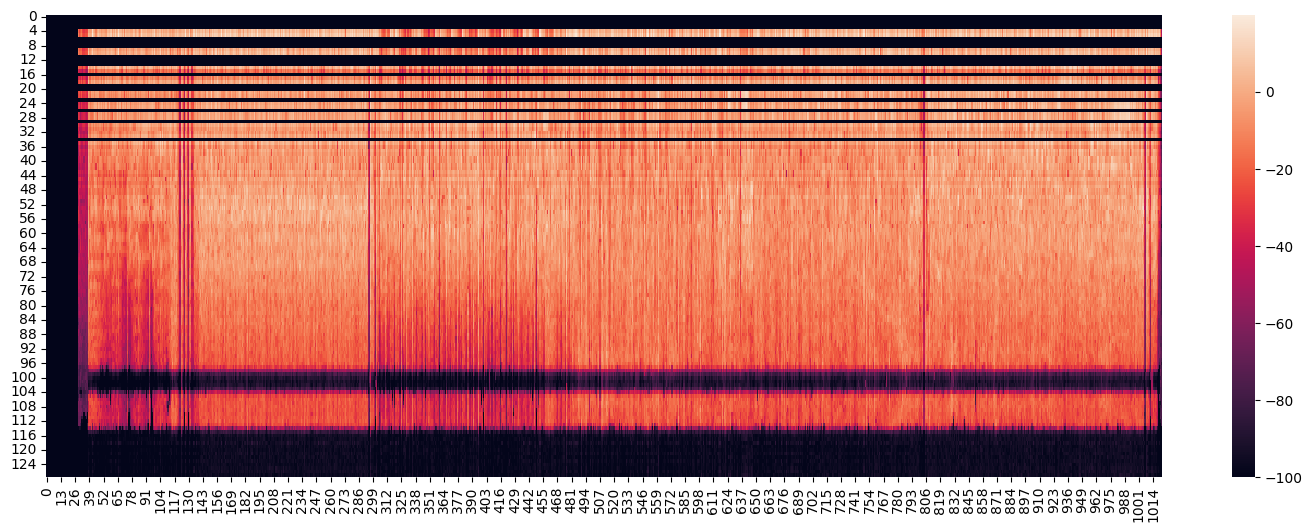

In [16]:
plt.figure(figsize=(18,6))
sns.heatmap(inter[0])

<Axes: >

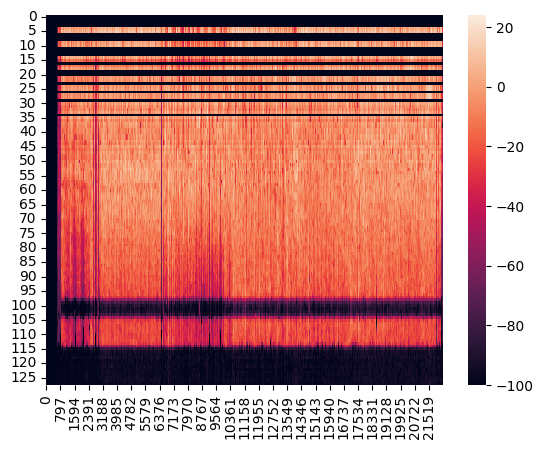

In [18]:
sns.heatmap(mel_db[0])

In [22]:
conv(mel_db).reshape(1, 4096, 128).shape

torch.Size([1, 4096, 128])

<Axes: >

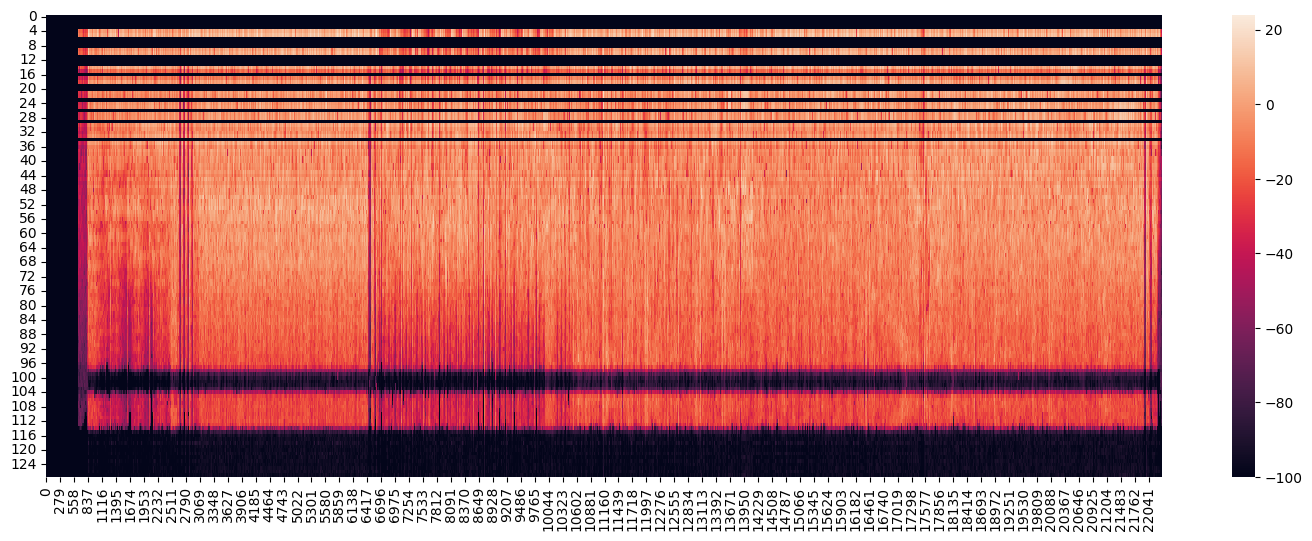

In [36]:
plt.figure(figsize=(18,6))
sns.heatmap(mel_db[0])

<Axes: >

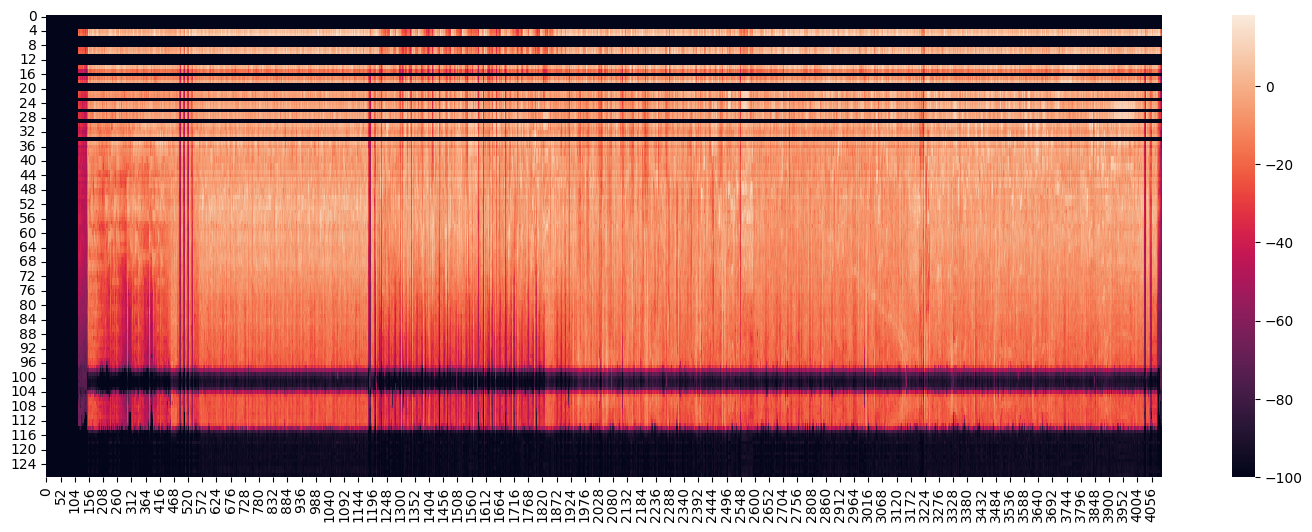

In [39]:
plt.figure(figsize=(18,6))
sns.heatmap(conv(mel_db)[0])

<Axes: >

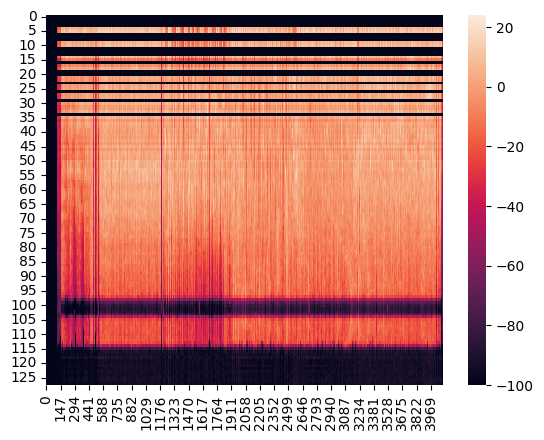

In [17]:
sns.heatmap(torchaudio.transforms.AmplitudeToDB()(conv(mel))[0])

In [6]:
TOKENIZER_PARAMS = {
    "pitch_range": (0, 127),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": False,
    "use_programs": False,
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
}
remi_config = TokenizerConfig(**TOKENIZER_PARAMS)

/tmp/ipykernel_126903/2731034332.py:14: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  remi_config = TokenizerConfig(**TOKENIZER_PARAMS)


In [7]:
tokenizer = REMI(remi_config)

In [20]:
tokenizer = REMI(params="song2midi/dataset/tokenizer.json")

/home/bk/miniconda3/envs/keras/lib/python3.11/site-packages/miditok/midi_tokenizer.py:3252: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  self.config = TokenizerConfig()
/home/bk/miniconda3/envs/keras/lib/python3.11/site-packages/miditok/classes.py:702: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  return cls(**input_dict, **kwargs)


In [8]:
midi_paths = list(Path("song2midi", "dataset", "midi").glob("*.mid"))

tokenizer.train(vocab_size=50265, files_paths=midi_paths)

In [11]:
tokenizer.save_params("song2midi/dataset/tokenizer.json")

In [23]:
score = Score("song2midi/dataset/midi_un_label/Shelter - Porter Robinson _ Madeon.mid")
miditok.utils.merge_same_program_tracks(score.tracks)

In [24]:
tokens = tokenizer(score)

In [25]:
len(tokens[0])

2158

In [26]:
tokenizer(tokens).dump_midi("song2midi/aaaaaaa.mid")

In [27]:
preprocess_data(tokenizer)

In [28]:
dataset = MusicDataset(tokenizer, ArrangerEmbedding(), max_output_length=4096, mel_processing=mel_interpolate)

In [11]:
for a in dataset:
    print(a["inputs_embeds"].shape, a["attention_mask"].shape, a["global_attention_mask"].shape, a["labels"].shape)

torch.Size([1024, 128]) torch.Size([1024]) torch.Size([1024]) torch.Size([4096])
torch.Size([1024, 128]) torch.Size([1024]) torch.Size([1024]) torch.Size([4096])
torch.Size([1024, 128]) torch.Size([1024]) torch.Size([1024]) torch.Size([4096])
torch.Size([1024, 128]) torch.Size([1024]) torch.Size([1024]) torch.Size([4096])
torch.Size([1024, 128]) torch.Size([1024]) torch.Size([1024]) torch.Size([4096])
torch.Size([1024, 128]) torch.Size([1024]) torch.Size([1024]) torch.Size([4096])
torch.Size([1024, 128]) torch.Size([1024]) torch.Size([1024]) torch.Size([4096])
torch.Size([1024, 128]) torch.Size([1024]) torch.Size([1024]) torch.Size([4096])
torch.Size([1024, 128]) torch.Size([1024]) torch.Size([1024]) torch.Size([4096])
torch.Size([1024, 128]) torch.Size([1024]) torch.Size([1024]) torch.Size([4096])


In [142]:
print(dataset[0])

{'inputs_embeds': tensor([[  0.5641,   0.9059,   0.2999,  ...,   1.0073,  -0.1278,  -1.5582],
        [-45.4692, -56.8909, -80.8566,  ..., -12.7225, -11.4234, -14.0303],
        [-15.0535, -18.3124, -20.4589,  ...,  -7.9617, -10.1642, -15.7700],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       grad_fn=<SqueezeBackward1>), 'attention_mask': tensor([1., 1., 1.,  ..., 0., 0., 0.]), 'global_attention_mask': tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32), 'labels': tensor([    1,  1782, 33547,  ...,  -100,  -100,  -100])}


In [10]:
print(dataset[0]["inputs_embeds"].shape, dataset[0]["attention_mask"].shape, dataset[0]["global_attention_mask"].shape, dataset[0]["labels"].shape)

torch.Size([1024, 128]) torch.Size([1024]) torch.Size([1024]) torch.Size([4096])


In [38]:
torch.tensor(tokenizer.encode(midi_paths[1])).squeeze(0).shape

torch.Size([514])

In [46]:
torch.cat([torch.tensor([tokenizer["BOS_None"]]), torch.tensor(tokenizer.encode(midi_paths[1])).squeeze(0), torch.tensor([tokenizer["EOS_None"]])], dim=-1)

tensor([    1,  1782, 33547, 46489, 24740, 24859, 25046, 35327, 30016, 25902,
        26131, 26351, 26620, 35581,  4965, 31132, 24978, 25252, 25413, 25571,
        37359, 48484, 26945, 32755, 36996, 41164, 37344, 42376, 45261, 43822,
        49963, 26924, 32770, 24920, 25169, 25324, 25547, 25745, 25889, 47998,
        26828, 27027, 34785, 24976, 37781, 48338, 26277, 26561, 40812,   425,
        32768, 37001, 47960, 23906, 40813, 45137, 49910, 26703, 26943, 32750,
        24851, 25064, 25303, 48064, 41165, 26507, 26781, 27055, 31147, 24927,
        25165, 25427, 25630, 47359, 36347, 35994, 33378, 41722, 25539, 47041,
        50087, 26390, 26672, 26831, 27222, 46962, 35321, 41179, 48873, 26545,
        41302, 48225, 31141, 25033, 37776, 25668, 41268, 38033, 43699, 26508,
        38555, 23511, 32769, 24929, 45172, 49728, 49973,  1062, 31168, 40392,
        43961, 40724, 26329, 47118, 46394, 36396, 40060, 25771, 38869, 40719,
        38599, 25308, 36434, 28520, 40713, 42526, 48025, 26026, 

In [8]:
from transformers import LEDConfig, LEDForConditionalGeneration

In [33]:
model_config = LEDConfig(
    vocab_size=tokenizer.vocab_size,
    # vocab_size=50265,
    activation_function="gelu",
    encoder_layers=8,
    decoder_layers=8,
    max_encoder_position_embeddings=1024,
    max_decoder_position_embeddings=4096,
    d_model=128,
    use_cache=False,
)

model = LEDForConditionalGeneration(model_config).to("cuda")

In [41]:
out = model(**dataset[0])

IndexError: too many indices for tensor of dimension 1

In [11]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

optimizer = AdamW(model.parameters(), lr=0.0001)
num_training_steps = len(train_dataloader) * 500
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Training Loop
num_train_epochs = 500
for epoch in range(num_train_epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_train_epochs}"):
        inputs_embeds = batch['inputs_embeds'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        global_attention_mask = batch['global_attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')
        
        outputs = model(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            global_attention_mask=global_attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

In [35]:
out

LEDSeq2SeqLMOutput(loss=tensor(10.8519, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[[ 0.1528,  0.0000,  1.7232,  ...,  0.0340, -0.2018,  0.2016],
         [ 0.0276,  0.0000,  0.0030,  ..., -0.0170,  0.3117, -0.0377],
         [ 0.1439,  0.0000, -0.2117,  ..., -0.1489, -0.0806,  0.2360],
         ...,
         [-0.0684,  0.0000,  0.4367,  ..., -0.0780,  0.1614, -0.0231],
         [-0.1011,  0.0000,  0.0282,  ...,  0.4681,  0.0164,  0.3435],
         [-0.4156,  0.0000, -0.0677,  ...,  0.2259, -0.0516, -0.0998]]],
       device='cuda:0', grad_fn=<AddBackward0>), past_key_values=None, decoder_hidden_states=None, decoder_attentions=None, cross_attentions=None, encoder_last_hidden_state=tensor([[[ 0.0419,  0.3264, -0.3593,  ...,  0.9347, -0.8379, -1.3963],
         [-0.3056,  0.7967, -0.5429,  ...,  1.9927,  0.8124,  0.7674],
         [-0.5460,  0.8657, -1.1845,  ..., -1.8351,  0.3854,  0.0470],
         ...,
         [ 2.3461,  2.7531,  2.2392,  ..., -0.1812, -0.4449, -0.2

In [30]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

2024-05-27 02:46:37.073858: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 02:46:37.187559: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 02:46:37.955908: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [1]:
from transformers import DataCollatorForSeq2Seq

class CustomDataCollator(DataCollatorForSeq2Seq):
    def __call__(self, features):
        inputs_embeds = [feature['inputs_embeds'] for feature in features]
        attention_mask = [feature['attention_mask'] for feature in features]
        global_attention_mask = [feature['global_attention_mask'] for feature in features]
        labels = [feature['labels'] for feature in features]
        
        # Convert lists to tensors
        inputs_embeds = torch.stack(inputs_embeds)
        attention_mask = torch.stack(attention_mask)
        global_attention_mask = torch.stack(global_attention_mask)
        labels = torch.stack(labels)
        
        return {
            'inputs_embeds': inputs_embeds,
            'attention_mask': attention_mask,
            'global_attention_mask': global_attention_mask,
            'labels': labels,
        }


2024-05-22 18:53:00.642409: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 18:53:00.671257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 18:53:01.290786: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [31]:
training_args = Seq2SeqTrainingArguments(
    output_dir="song2midi/results",
    auto_find_batch_size=True,
    log_level="debug",
    save_strategy="epoch",
    bf16_full_eval=True,
    save_total_limit=3,
)

In [35]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=dataset,
)

In [36]:
trainer.train()

Currently training with a batch size of: 8
***** Running training *****
  Num examples = 46
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18
  Number of trainable parameters = 25,926,272
Currently training with a batch size of: 4
***** Running training *****
  Num examples = 46
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Training with DataParallel so batch size has been adjusted to: 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 36
  Number of trainable parameters = 25,926,272
Currently training with a batch size of: 2
***** Running training *****
  Num examples = 46
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Training with DataParallel so batch size has been adjusted to: 2
  Total train batch size (w. parallel, distribu

In [16]:
out.keys()

odict_keys(['logits', 'past_key_values', 'encoder_last_hidden_state'])

In [ ]:
miditok.utils.filter_dataset(Path("song2midi", "dataset", "midi").glob("*.mid"), )

In [55]:
from symusic import Score

In [71]:
aaa = Score("song2midi/dataset/midi/This_Game.mid")

In [77]:
miditok.utils.merge_same_program_tracks(aaa.tracks)

In [78]:
aaa

Score(ttype=Tick, tpq=480, begin=0, end=138155, tracks=1, notes=1488, time_sig=1, key_sig=4, markers=0, lyrics=0)

In [16]:
y, sr = librosa.load("song2midi/dataset/wav/Idol.wav")

In [17]:
y.shape, sr

((4978177,), 22050)

In [19]:
mel = librosa.feature.melspectrogram(y=y, sr=sr)

In [21]:
mel.shape

(128, 9724)

In [31]:
4978177 - 5418423

-440246